**ML of the industrial process of extracting metals**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc={'figure.figsize':(10,5)})
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
test = pd.read_csv('gold_recovery_test.csv')

In [3]:
train = pd.read_csv('gold_recovery_train.csv')

In [4]:
full = pd.read_csv('gold_recovery_full.csv')

# Check calculation of rougher.output.recovery

**Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.**

In [5]:
recovery_calculated = (train['rougher.output.concentrate_au']*
                       (train['rougher.input.feed_au'] - train['rougher.output.tail_au'])/
                       (train['rougher.input.feed_au']*
                        (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))*100)

In [6]:
abs(recovery_calculated- train['rougher.output.recovery']).mean()

9.303415616264301e-15

**Conclusion**

rougher.output.recovery calculated correctly

# Analyze the features not available in the test set.

In [7]:
[col for col in train.columns if col not in test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Conclusion**

We have most of columns with output and calculation 
Some parameters are not available because they were calculated much later. That's why, some of the features that are present in the training set may be absent from the test set.

# Data preprocessing

In [8]:
train.isna().mean()[train.isna().mean() > 0.05]

final.output.recovery                 0.090214
primary_cleaner.input.sulfate         0.077521
primary_cleaner.input.depressant      0.074852
primary_cleaner.input.xanthate        0.058422
rougher.calculation.au_pb_ratio       0.073665
rougher.input.floatbank10_sulfate     0.061922
rougher.input.floatbank11_xanthate    0.112930
rougher.output.recovery               0.152610
rougher.output.tail_ag                0.133452
rougher.output.tail_sol               0.133393
rougher.output.tail_au                0.133393
secondary_cleaner.output.tail_sol     0.117794
dtype: float64

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar. We use ffil method

In [9]:
train = train.fillna(method='ffill')

In [10]:
train.isna().mean()[train.isna().mean() != 0]

Series([], dtype: float64)

**Conclusion**

We filled in missing values with the last valid observation in the forward direction.


# Concentrations of metals (Au, Ag, Pb) on different purification stages

In [11]:
steps = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

In [12]:
def get_hist(elem):
    for step in steps:
        step = step + elem
        train[step].plot(kind = 'hist', alpha = 0.7, bins = 30,  legend = 'step')
        plt.title(f'Concentration of {elem} by stages')

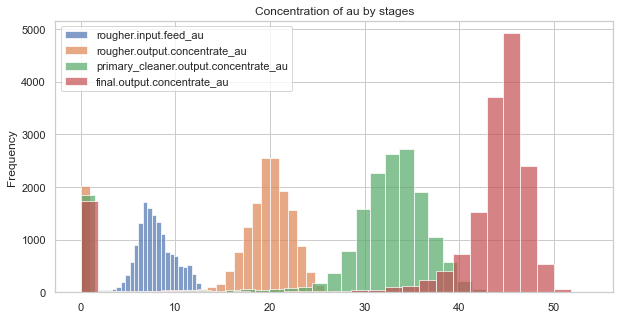

In [13]:
get_hist('au')

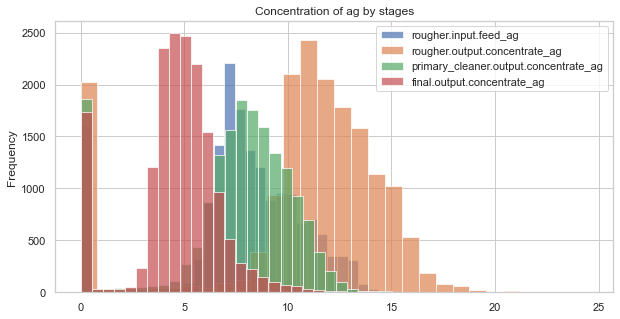

In [14]:
get_hist('ag')

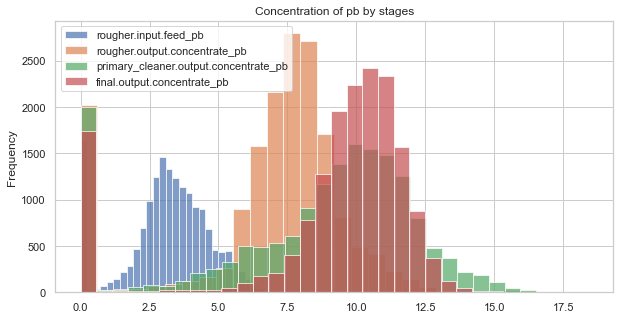

In [15]:
get_hist('pb')

**Conclusion**
- concentration of gold increases
- concentration of ag decreases
- concentration of pb increases

# Feed particle size distributions in the training set and in the test set

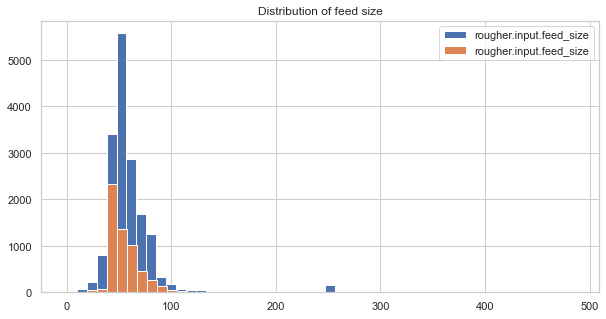

In [16]:
train['rougher.input.feed_size'].hist(bins = 50, legend = 'Feed size in train dataframe')
test['rougher.input.feed_size'].hist(bins = 50, legend = 'Feed size in test dataframe')
plt.title('Distribution of feed size');

In [17]:
pd.concat([train['rougher.input.feed_size'].describe(), test['rougher.input.feed_size'].describe()], axis = 1)

,rougher.input.feed_size,rougher.input.feed_size
count,16860.000000,5834.000000
mean,60.188595,55.937535
std,30.522242,22.724254
min,9.659576,0.046369
25%,47.548897,43.890852
50%,54.066003,50.002004
75%,65.397249,61.638434
max,484.967466,477.445473


**Conclusion**
- in train dataframe we have feed_size a bit bigger than in test dataframe 
- in general distributions are similar 
- we can see that distribution a bit right squized - there are particles with big size


# Total concentrations of all substances at different stages

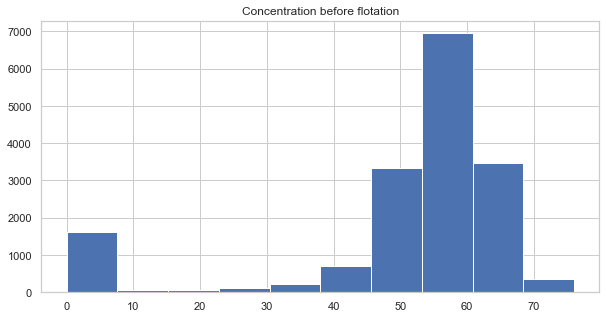

In [18]:
train[[x for x in train.columns if 'rougher.input.feed_' in x and 'size' not in x and 'rate' not in x]].sum(1).hist()
plt.title('Concentration before flotation');

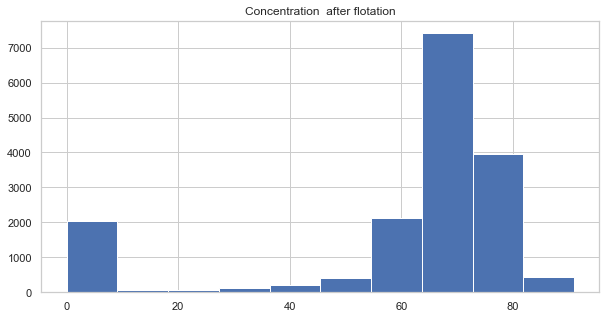

In [19]:
train[[x for x in train.columns if 'rougher.output.concentrate_' in x]].sum(1).hist()
plt.title('Concentration  after flotation');

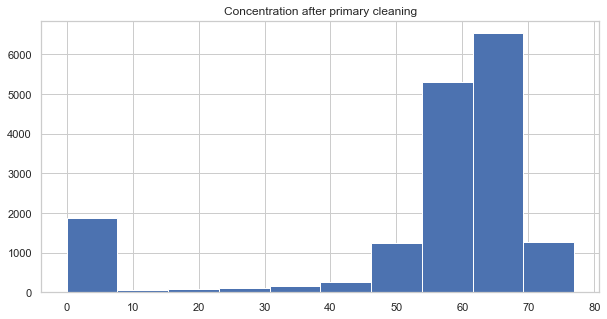

In [20]:
train[[x for x in train.columns if 'primary_cleaner.output.concentrate_' in x]].sum(1).hist()
plt.title('Concentration after primary cleaning');

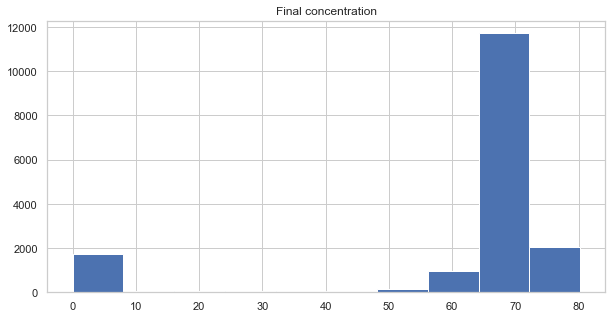

In [21]:
train[[x for x in train.columns if 'final.output.concentrate_' in x]].sum(1).hist()
plt.title('Final concentration');

**Conclusion**

We have rows with 0 concentration of all components in different stages - It can be reason of technical problem with instruments for mesuring the concentration We have to drop rows like this

In [22]:
train = train[train[[x for x in train.columns if 'rougher.input.feed_' in x and 'size' not in x and 'rate' not in x]].sum(1) > 0]
train = train[train[[x for x in train.columns if 'rougher.output.concentrate_' in x]].sum(1)>0]
train = train[train[[x for x in train.columns if 'primary_cleaner.output.concentrate_' in x]].sum(1)>0]
train = train[train[[x for x in train.columns if 'final.output.concentrate_' in x]].sum(1)>0]
len(train)

15026

In [23]:
full = full[full[[x for x in full.columns if 'rougher.input.feed_' in x and 'size' not in x and 'rate' not in x]].sum(1) > 0]
full = full[full[[x for x in full.columns if 'rougher.output.concentrate_' in x]].sum(1)>0]
full = full[full[[x for x in full.columns if 'primary_cleaner.output.concentrate_' in x]].sum(1)>0]
full = full[full[[x for x in full.columns if 'final.output.concentrate_' in x]].sum(1)>0]
len(full)

20238

In [24]:
test = test.query('date in @full["date"]')
len(test)

5244

**Conclusion**

We remove rows with total concentration of elements = 0

# Linear Regression with K-fold

In [25]:
features = train[[x for x in train.columns if x in test.columns]].drop('date', axis = 1).reset_index(drop= True)
target= train[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop = True)
target.columns = [0, 1]

In [26]:
def get_smape(predicted_valid, target_valid):
    errors = []
    predicted_valid = pd.DataFrame(predicted_valid)
    smape = (np.abs(target_valid - predicted_valid)/(target_valid + predicted_valid)*2).mean()
    errors.append(smape[0]*0.25 + smape[1]*0.75)
    return round(pd.Series(errors).mean(), 3)
    
    

In [27]:
def get_smape_model(model, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, valid_index in kf.split(features):
        features_train, features_valid = features.iloc[train_index].reset_index(drop = True), features.iloc[valid_index].reset_index(drop = True)
        target_train, target_valid = target.iloc[train_index].reset_index(drop = True), target.iloc[valid_index].reset_index(drop = True)

        model = model
        model.fit(features_train, target_train)
    

        predicted_valid = model.predict(features_valid)
        res = get_smape(predicted_valid, target_valid)
       
    print(f'Final sMAPE of {model} = {res}')

In [28]:
model = LinearRegression()
get_smape_model(model)

Final sMAPE of LinearRegression() = 0.087


# RandomForestRegressor

In [29]:
for depth in [2, 4, 6, 8]:
    model = RandomForestRegressor(max_depth = depth, n_estimators = 50, random_state = 13)
    get_smape_model(model, k=5)
        

Final sMAPE of RandomForestRegressor(max_depth=2, n_estimators=50, random_state=13) = 0.093
Final sMAPE of RandomForestRegressor(max_depth=4, n_estimators=50, random_state=13) = 0.083
Final sMAPE of RandomForestRegressor(max_depth=6, n_estimators=50, random_state=13) = 0.076
Final sMAPE of RandomForestRegressor(max_depth=8, n_estimators=50, random_state=13) = 0.071


**Conclusion**

We choose RandomForestRegressor with max_depth = 8

# Prediction for test dataset

In [31]:
model = RandomForestRegressor(max_depth=8, n_estimators = 50, random_state=13)
model.fit(features, target)
predicted = model.predict(features)
res = get_smape(predicted, target)
print(f'Final smape for train data : {res}')

Final smape for train data : 0.066


In [32]:
target_test =(full.query('date in @test["date"]')
              .sort_values(by = 'date')[['rougher.output.recovery', 'final.output.recovery']]
              .fillna(method = 'ffill')
              .reset_index(drop = True))
target_test.columns = [0, 1]
features_test = test.sort_values(by = 'date').drop('date', axis = 1).fillna(method = 'ffill') 

In [33]:
model.fit(features, target)
predicted_test = model.predict(features_test)
res = get_smape(predicted_test, target_test)
print(f'Final smape for test data : {res}')

Final smape for test data : 0.073


**General conclusion** 

Model that perform the best results is RandomForestRegressor with max_depth = 8